<a href="https://colab.research.google.com/github/VAZaytsev/FlowerClassifier/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower classifier
We construct the flower classifier on the basis of the [dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/), consisting of 102 flower classes. In each class, there are from 40 to 258 images. To convert each image into a feature vector we will use a pre-trained convolutional neural network ResNet-50, which was first presented in this [preprint](https://arxiv.org/abs/1512.03385) and currently can be found in many machine learning frameworks. Here we will use TensorFlow.

Similar projects can be found [here](https://towardsdatascience.com/build-train-and-deploy-a-real-world-flower-classifier-of-102-flower-types-a90f66d2092a) and [here](https://www.kaggle.com/code/dtosidis/flower-classifier-tensorflow/notebook). 

First, let's load the necessary packages for visualizing the data

In [1]:
import matplotlib.pyplot as plt

Now we load everything needed for the creation of the classifier from TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense

import tensorflow_hub as hub

from tensorflow.keras.optimizers import Adam

We now load the dataset with the flowers images from TensorFlow (some details can be found in a [documentation](https://www.tensorflow.org/datasets/catalog/oxford_flowers102))

In [3]:
import tensorflow_datasets as tfds

ds, ds_info = tfds.load('oxford_flowers102', 
                        with_info=True, 
                        as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteK7YGMQ/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteK7YGMQ/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteK7YGMQ/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


Let's print the number of classes and the sizes of the training, validation, and testing datasets. Following the original [paper](https://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/), for both the training and validation sets from each class 10 images are taken (1020 images per each set). The testing set consists of the remaining 6149 images. Note that in such separation the size of the testing set is much larger that the ones of the training and validation. 

In [4]:
Nclasses = ds_info.features['label'].num_classes
print('Number of classes = ', Nclasses)

print('Training set size = ', len(ds['train']) )
print('Validation set size = ', len(ds['validation']) )
print('Testing set size = ', len(ds['test']) )

Number of classes =  102
Training set size =  1020
Validation set size =  1020
Testing set size =  6149


Let's see how do the images look like

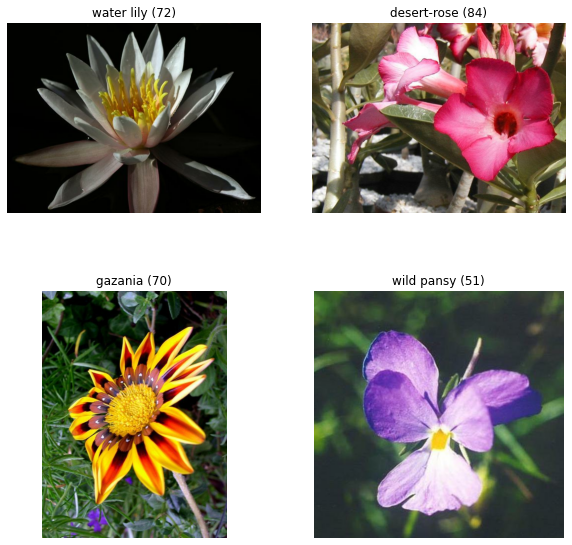

In [5]:
plt.figure(figsize=(10, 10))

N = 2

pos = 0
for image, label in ds['train'].take(N**2):
  name = ds_info.features['label'].names[int(label)]
  ax = plt.subplot(N, N, pos + 1)
  plt.imshow(image.numpy())
  plt.title( name + ' (' + str(int(label)) + ')' )
  plt.axis("off")
  pos = pos + 1

We now turn to the construction of the model. The shape of the input layer is D x D x 3, where D is the size of the image and additional dimension 3 encodes the colors. The input layer is followed by the network ResNet-50 with fixed weights, which won't be changed in course of training. An output layer has one neuron per class, in our case that is 102 neurons. The function below will construct and compile the model.

In [6]:
def prepare_model(learning_rate=0.001, image_size=224):
  URL = "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5"
  feature_extractor = hub.KerasLayer(URL, 
                                     input_shape=(image_size, image_size, 3), 
                                     trainable=False)

  tf.keras.backend.clear_session()
  model = Sequential([feature_extractor, 
                      #Flatten(), 
                      Dense(Nclasses, activation='softmax')])

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

Before training the model one needs to preprocess the images and prepare the data sets. Initially, the size of an image from the data set is at least 500 in each dimension. One needs to rescale it to a given size. Moreover, the value of each color should be mapped to the range [0,1] from [0,255]. We also separate the dataset into butches and shuffle the data (if needed). Here we shuffle the complete data set following TensorFlow [tips](https://www.tensorflow.org/datasets/performances). For the details about [cache](https://www.tensorflow.org/guide/data_performance#caching) and [prefetch](https://www.tensorflow.org/guide/data_performance#prefetching), we refer to the documentation. 

In [7]:
def prepare_data(data_set, batch_size=32, image_size=224, shuffle=True):

  def parse_image(image, label):
    image = tf.image.resize(image, (image_size, image_size)) / 255.0 #Normalizes images: `uint8` -> `float32`.
    return image, label

  data_set = data_set.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
  #data_set = data_set.cache()
  if shuffle:
    data_set = data_set.shuffle(len(data_set))
  data_set = data_set.batch(batch_size)
  data_set = data_set.prefetch(tf.data.experimental.AUTOTUNE)

  return data_set

We now set the parameters and train the model. Here we use the parameters which minimize the validation loss. It appeared that the most important parameter is the image size. If it is too small, e.g. 180, the accuracy of the validation set is relatively small. It is also unnecessary to use a size bigger than 300 since it doesn't influence accuracy anymore.

In [8]:
# Set parameters 
epochs = 20
image_size = 300

batch_size = 32
learning_rate = 0.001

# Clear session
tf.keras.backend.clear_session()

# Create the model
model = prepare_model(learning_rate=learning_rate, image_size=image_size)
model.summary()

train_ds = prepare_data(ds['train'], batch_size=batch_size, image_size=image_size)

# There is no need to shuffle validation or testing data 
validation_ds = prepare_data(ds['validation'], batch_size=batch_size, image_size=image_size, shuffle=False)
test_ds = prepare_data(ds['test'], batch_size=batch_size, image_size=image_size, shuffle=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,770,150
Trainable params: 208,998
Non-trainable params: 23,561,152
_________________________________________________________________


In [9]:
history = model.fit(train_ds, 
                    validation_data=validation_ds, 
                    epochs=epochs)

Epoch 1/20
32/32 [==============================] - 27s 344ms/step - loss: 4.2422 - accuracy: 0.1255 - val_loss: 2.9518 - val_accuracy: 0.4176
Epoch 2/20
32/32 [==============================] - 12s 301ms/step - loss: 1.9463 - accuracy: 0.7343 - val_loss: 1.8413 - val_accuracy: 0.7186
Epoch 3/20
32/32 [==============================] - 12s 302ms/step - loss: 0.9623 - accuracy: 0.9382 - val_loss: 1.3715 - val_accuracy: 0.7922
Epoch 4/20
32/32 [==============================] - 11s 265ms/step - loss: 0.5541 - accuracy: 0.9853 - val_loss: 1.1423 - val_accuracy: 0.8108
Epoch 5/20
32/32 [==============================] - 13s 303ms/step - loss: 0.3561 - accuracy: 0.9941 - val_loss: 0.9940 - val_accuracy: 0.8245
Epoch 6/20
32/32 [==============================] - 12s 266ms/step - loss: 0.2469 - accuracy: 0.9971 - val_loss: 0.9073 - val_accuracy: 0.8333
Epoch 7/20
32/32 [==============================] - 11s 276ms/step - loss: 0.1820 - accuracy: 1.0000 - val_loss: 0.8452 - val_accuracy: 0.8461

The training curve looks as follows.

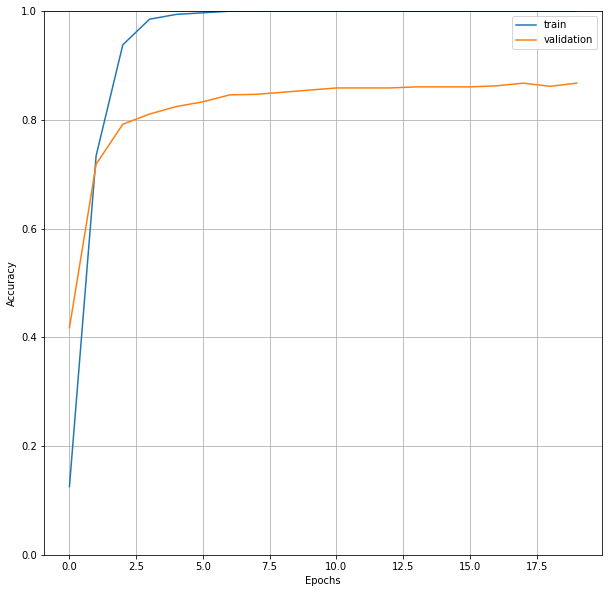

In [10]:
plt.figure(figsize=(10, 10))

epochs_range= range(epochs)

plt.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.0,ymax=1)
plt.grid()

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

We now check the performance of our model on the testing set.

In [11]:
results = model.evaluate(test_ds)
print("test loss, test acc:", results)

193/193 [==============================] - 27s 140ms/step - loss: 0.7057 - accuracy: 0.8458
test loss, test acc: [0.7056573033332825, 0.8458285927772522]


Note that the accuracy obtained in the original work is 0.728 meanwhile here we reached 0.84.

##Nice part
Of course we now can analyse the results, e.g. plot an accuracy for each class, find most difficult flowers to recognize and etc. But this is not so interesting. I decided to check like which flower my wife will be classified. For this purpose we need to load couple of photos and process them properly. 

In [14]:
import numpy as np
from PIL import Image

def process_img(img):
  img_np = np.asarray(img)
  img_tf = tf.image.resize(img_np, (image_size, image_size)) / 255.0
  img_tf = np.expand_dims(img_tf, axis=0)
  return img_tf

Below we load the photos, make predictions, and for each photo we choose 3 flower classes, which fits most.

In [92]:
import requests
from io import BytesIO

page1 = requests.get('https://raw.githubusercontent.com/VAZaytsev/FlowerClassifier/main/m1.jpg')
m1 = Image.open(BytesIO(page1.content))

page2 = requests.get('https://raw.githubusercontent.com/VAZaytsev/FlowerClassifier/main/m2.jpg')
m2 = Image.open(BytesIO(page2.content))

m1_tf = process_img(m1)
m2_tf = process_img(m2)

vals1, labels1 = tf.math.top_k( model.predict(m1_tf, verbose=0), 3)
vals2, labels2 = tf.math.top_k( model.predict(m2_tf, verbose=0), 3)

labels1 = np.squeeze(labels1.numpy()).tolist()
labels2 = np.squeeze(labels2.numpy()).tolist()

vals1 = [round(100*x) for x in np.squeeze(vals1.numpy()).tolist()]
vals2 = [round(100*x) for x in np.squeeze(vals2.numpy()).tolist()]

We now pick the corresponding flower samples from the data set.

In [93]:
imgs1 = []
imgs2 = []
for image, label in ds['test']:
  l1 = len(imgs1)
  if l1 < 3:
    if int(label) == int(labels1[l1]):
      img_scld = tf.image.resize(image, (image_size, image_size)) / 255.0
      imgs1.append(img_scld)

  l2 = len(imgs2)
  if l2 < 3:
    if int(label) == int(labels2[l2]):
      img_scld = tf.image.resize(image, (image_size, image_size)) / 255.0
      imgs2.append(img_scld)

  if l1 == 3 and l2 == 3:
    break

Let's see the pictures!

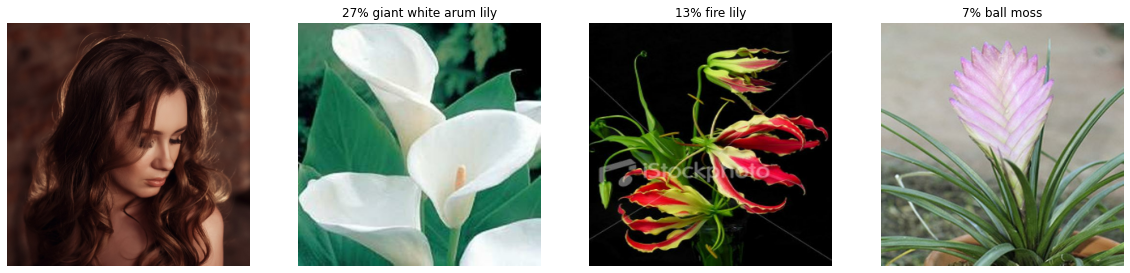

In [94]:
plt.figure(figsize=(20,20))

ax = plt.subplot(1, 4, 1)
plt.imshow(m1)
plt.axis("off")

for i,x in enumerate(imgs1):
  ax = plt.subplot(1, 4, 2+i)
  name = ds_info.features['label'].names[labels1[i]]
  plt.title( str(vals1[i]) + '% ' + name )
  plt.imshow(x.numpy())
  plt.axis("off")

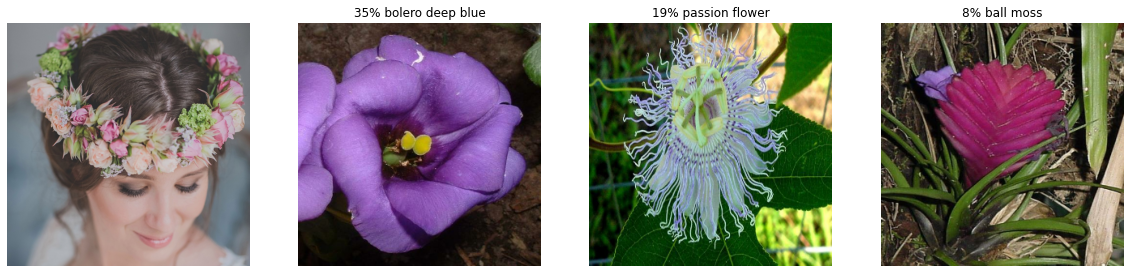

In [88]:
plt.figure(figsize=(20,20))

ax = plt.subplot(1, 4, 1)
plt.imshow(m2)
plt.axis("off")

for i,x in enumerate(imgs2):
  ax = plt.subplot(1, 4, 2+i)
  name = ds_info.features['label'].names[labels2[i]]
  plt.title( str(vals2[i]) + '% ' + name )
  plt.imshow(x.numpy())
  plt.axis("off")